<a href="https://colab.research.google.com/github/iamsaver/HW4/blob/main/HW4%3DL16Transfer_Learning_Part5_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic : Lecture 16 Transfer Learning

Follow the CRSIP-DM method
1. Step 1: Import library, import data
2. Step 2: Pre-processing (missing data, categorical type, normalization, format transform, data augmentation)
3. Step 3: Build ML Model
4. Step 4: Evaluate Model
5. Step 5: Deploy (Prediction)


## Step 1:  Load data (also import library)

In [ ]:
!pip install torch torchvision
!pip install Pillow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import library
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
print(device)

cuda:0


In [ ]:
# get data  (homework 4 要找一個github, 裡面有dataset的folder)
#!git clone https://github.com/jaddoescad/ants_and_bees.git
!git clone https://github.com/ardamavi/Dog-Cat-Classifier.git
# !rm -rf ./Face-Mask-Detection/
# !rm -rf ./ants_and_bees/



Cloning into 'Dog-Cat-Classifier'...
remote: Enumerating objects: 1654, done.
remote: Total 1654 (delta 0), reused 0 (delta 0), pack-reused 1654
Receiving objects: 100% (1654/1654), 34.83 MiB | 35.66 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [ ]:
!ls ./Dog-Cat-Classifier/Data/Train_Data/

cat  dog


# Step 2: Pre-process X, Y
* format transform (轉換成numpy format)
* missing data (imputation)差補
* category data transform 
* data augmentation
* normalization


In [ ]:
transform_train = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
          transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])


transform = transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_dataset = datasets.ImageFolder('Dog-Cat-Classifier/Data/Train_Data/', transform=transform)
validation_dataset = datasets.ImageFolder('Dog-Cat-Classifier/Data/Train_Data/', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)


In [ ]:
print(len(training_dataset))
print(len(validation_dataset))

1399
1399


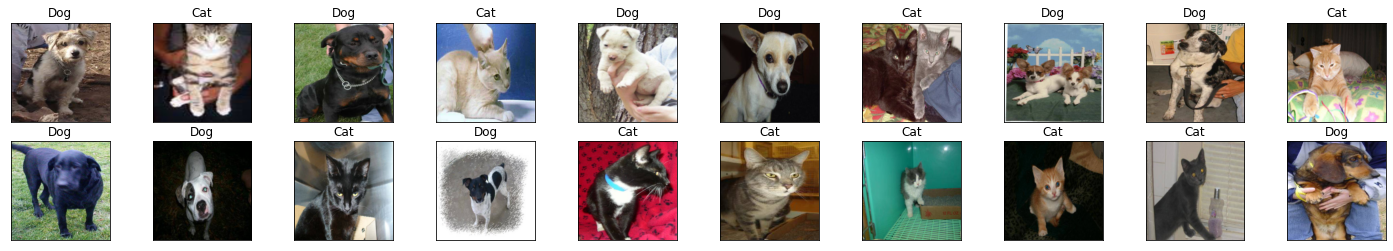

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

# !ls ./Dog-Cat-Classifier/Data/Train_Data/

classes=('Cat','Dog')

dataiter = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

# Step 3: Build Model for training

<img src="https://ithelp.ithome.com.tw/upload/images/20171206/20001976yeCo1PvEOs.jpg" width=500 />

In [ ]:
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# turn off gradient for all parameters in features extraction 
for param in model.features.parameters():
  param.requires_grad = False

# modify last node from 1000 to 2 
# import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

print("output features=",model.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Step 4 Training Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
epochs = 2
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.0059, acc 0.9543 
validation loss: 0.0003, validation acc 0.9979 
epoch : 2
training loss: 0.0005, acc 0.9943 
validation loss: 0.0001, validation acc 1.0000 


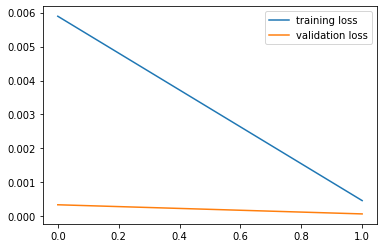

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

## Step 5 Testing
### Cat
<img src="https://cdn.bella.tw/index_image/SIXlRaTmfMy5HlCHixB9BrxUUJEO0RsHCitEVCpV.jpeg" alt="Cat" width="300"/>


### Dog
<img src="https://ichef.bbci.co.uk/news/640/cpsprodpb/167DF/production/_112272129_gettyimages-905087342.jpg" alt="mask" width="300"/>


In [ ]:
!pip3 install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import PIL.ImageOps

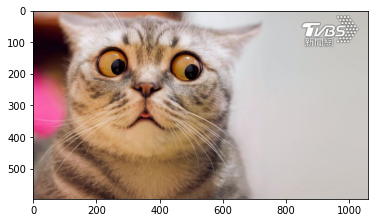

In [ ]:
import requests
from PIL import Image

# url = 'https://cdn.bella.tw/index_image/SIXlRaTmfMy5HlCHixB9BrxUUJEO0RsHCitEVCpV.jpeg'
# url ='https://ichef.bbci.co.uk/news/640/cpsprodpb/167DF/production/_112272129_gettyimages-905087342.jpg'
url='https://cc.tvbs.com.tw/img/upload/2022/05/20/20220520170357-1298d211.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

## Step 5 Testing
### Cat
<img src="https://cdn.bella.tw/index_image/SIXlRaTmfMy5HlCHixB9BrxUUJEO0RsHCitEVCpV.jpeg" alt="Cat" width="300"/>


### Dog
<img src="https://ichef.bbci.co.uk/news/640/cpsprodpb/167DF/production/_112272129_gettyimages-905087342.jpg" alt="mask" width="300"/>


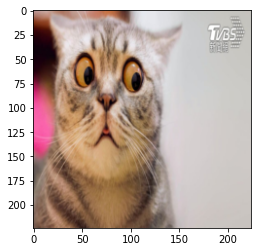

In [ ]:
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

Cat
